<a href="https://colab.research.google.com/github/musajalili/band-e-amir-surface-water-monitoring/blob/main/GRACE_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of GRACE Mascon Data for Terrestrial Water and Ice Mass Changes

This notebook implements the analysis step by step using Google Colab. It downloads the required data and shapefiles, processes the GRACE Mascon data, and performs the requested tasks.

Note: The GRACE data file is assumed to be available at the OPENDAP URL based on 2025 date. If the exact file is not found, replace with the latest available from PO.DAAC.

In [ ]:
!pip install xarray geopandas cartopy rioxarray regionmask scipy statsmodels matplotlib pandas netcdf4 -q

In [ ]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.stats import linregress
import numpy as np
import pandas as pd
import regionmask
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Download GRACE Mascon data (adjust URL if needed for latest)
# !wget -O grace.nc https://podaac-opendap.jpl.nasa.gov/opendap/allData/tellus/L3/mascon/RL06.3/v04/cri/GRCTellus.JPL.200204_202507.GLO.RL06.3M.MSCNv04CRI.nc

# ds = xr.open_dataset('grace.nc')
nc_path = "/content/GRCTellus.JPL.200204_202507.GLO.RL06.3M.MSCNv04CRI.nc"
ds = xr.open_dataset(nc_path)

# Inspect variables
print(ds)

ds = ds.rio.write_crs('epsg:4326')
print(ds)

<xarray.Dataset> Size: 2GB
Dimensions:        (time: 247, lat: 360, lon: 720, bounds: 2)
Coordinates:
  * lon            (lon) float64 6kB 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
  * lat            (lat) float64 3kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2kB 2002-04-17T12:00:00 ... 2025-07-...
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 512MB ...
    uncertainty    (time, lat, lon) float64 512MB ...
    lat_bounds     (lat, bounds) float64 6kB ...
    lon_bounds     (lon, bounds) float64 12kB ...
    time_bounds    (time, bounds) datetime64[ns] 4kB ...
    land_mask      (lat, lon) float64 2MB ...
    scale_factor   (lat, lon) float64 2MB ...
    mascon_ID      (lat, lon) float64 2MB ...
    GAD            (time, lat, lon) float64 512MB ...
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0

## 1. Global Map of TWSA for a Chosen Month
Chosen month: April 2010

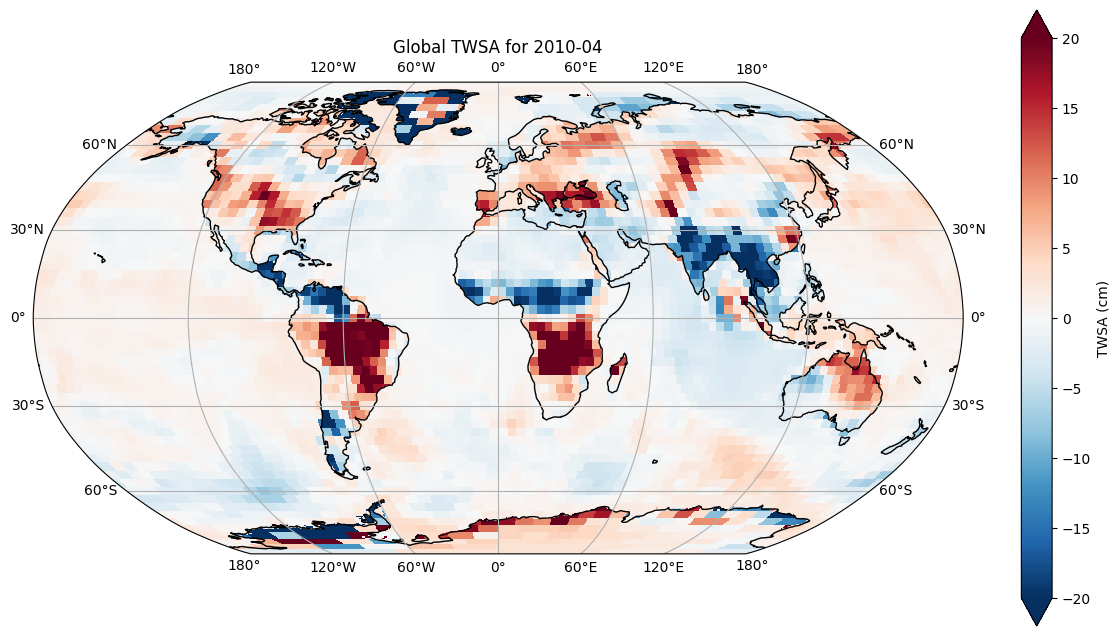

In [ ]:
chosen_time = '2010-04-15'  # Approximate mid-month
month_data = ds['lwe_thickness'].sel(time=chosen_time, method='nearest')

fig = plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.Robinson())
month_data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-20, vmax=20, cbar_kwargs={'label': 'TWSA (cm)'})
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.title(f'Global TWSA for {chosen_time[:7]}')
plt.show()

## 2. TWSA over Afghanistan

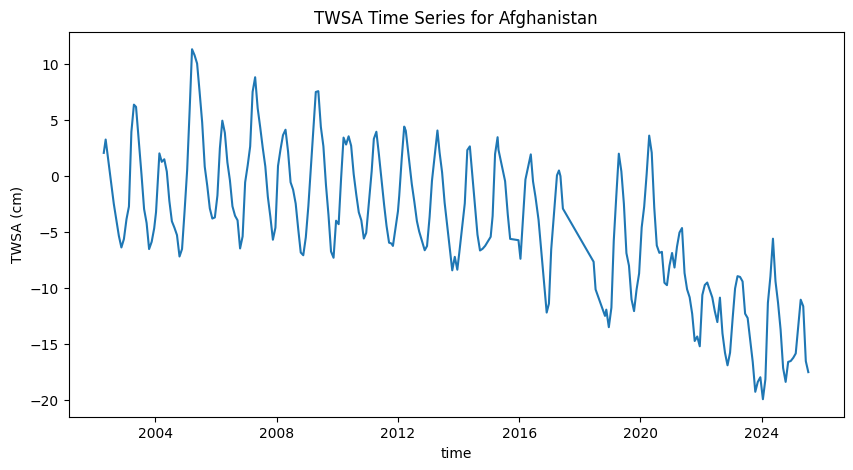

Trend: -0.74 cm/year
Afghanistan water loss: -4820.78 Gt/year
Remarkable low years: [2018 2021 2022 2023 2024 2025]
Remarkable high years: [2003 2005 2006 2007 2008 2009 2011 2012 2013]


In [ ]:
import geopandas as gpd
import regionmask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load shapefile (make sure CRS is WGS84)
afg = gpd.read_file("afg_shp/Afghanistan_Shapefile.shp")
afg = afg.to_crs("EPSG:4326")  # just in case

# Create regionmask (Afghanistan = single region -> region 0)
mask_afg = regionmask.from_geopandas(afg)
mask3d_afg = mask_afg.mask_3D(ds.lon, ds.lat)

# Area weights (latitudinal weighting + mask for region 0)
weights_afg = np.cos(np.deg2rad(ds.lat)) * mask3d_afg.sel(region=0)
weights_afg.name = "weights"

# Area-weighted TWSA for Afghanistan
twsa_afg = ds["lwe_thickness"].where(mask3d_afg.sel(region=0)) \
                               .weighted(weights_afg) \
                               .mean(["lon", "lat"])

# Plot time series
twsa_afg.plot(figsize=(10, 5))
plt.title("TWSA Time Series for Afghanistan")
plt.ylabel("TWSA (cm)")
plt.show()

# Linear trend (monthly → yearly)
time_num = np.arange(len(twsa_afg.time))
valid = ~np.isnan(twsa_afg.values)
slope, intercept, r, p, se = linregress(time_num[valid], twsa_afg.values[valid])
trend_cm_yr = slope * 12  # cm/year
print(f"Trend: {trend_cm_yr:.2f} cm/year")

# Water loss in Gt/year (area of Afghanistan ~652,230 km²)
area_afg = 652230  # km²
loss_gt_yr = trend_cm_yr * area_afg * 0.01   # (1 cm over 1 km² = 0.01 Gt)
print(f"Afghanistan water loss: {loss_gt_yr:.2f} Gt/year")

# Extreme years (min/max anomalies per year)
twsa_df = pd.DataFrame({"time": twsa_afg.time.values, "twsa": twsa_afg.values})
twsa_df["year"] = pd.to_datetime(twsa_df["time"]).dt.year

annual_min = twsa_df.loc[twsa_df.groupby("year")["twsa"].idxmin()]
annual_max = twsa_df.loc[twsa_df.groupby("year")["twsa"].idxmax()]

low_years = annual_min[annual_min["twsa"] < twsa_df["twsa"].quantile(0.1)]["year"].values
high_years = annual_max[annual_max["twsa"] > twsa_df["twsa"].quantile(0.9)]["year"].values

print("Remarkable low years:", low_years)
print("Remarkable high years:", high_years)


## 3. Mask Mascons over Asia

Archive:  Asia_Shapefile.zip
  inflating: world_shp/Asia_Shapefile.cpg  
  inflating: world_shp/Asia_Shapefile.shx  
  inflating: world_shp/Asia_Shapefile.shp  
  inflating: world_shp/Asia_Shapefile.prj  
  inflating: world_shp/Asia_Shapefile.fix  
  inflating: world_shp/Asia_Shapefile.dbf  


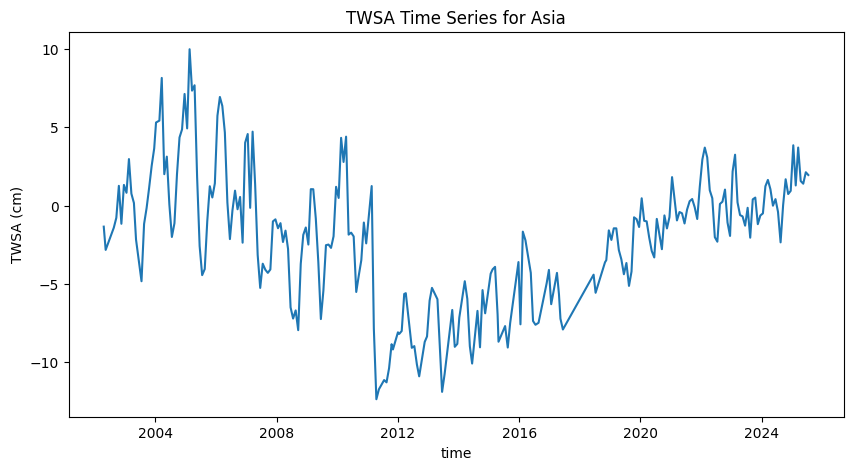

Trend: -0.07 cm/year
Asia TWS loss: -29647.24 Gt/year


In [ ]:
!unzip -o Asia_Shapefile.zip -d world_shp

import geopandas as gpd
import regionmask
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load shapefile (Asia boundary)
asia = gpd.read_file("world_shp/Asia_Shapefile.shp").to_crs("EPSG:4326")

# Create regionmask (single mask, not 3D)
mask_asia = regionmask.from_geopandas(asia).mask(ds.lon, ds.lat)

# Convert mask into 2D boolean
mask_asia_bool = mask_asia == 0  # region index 0 = Asia

# Apply mask
twsa_asia = ds["lwe_thickness"].where(mask_asia_bool)

# Add latitude weights (cosine weighting)
weights_asia = np.cos(np.deg2rad(ds.lat))

# Weighted average over Asia
twsa_asia_mean = twsa_asia.weighted(weights_asia).mean(["lon", "lat"])

# Plot time series
twsa_asia_mean.plot(figsize=(10,5))
plt.title("TWSA Time Series for Asia")
plt.ylabel("TWSA (cm)")
plt.show()

# Linear trend
time_num = np.arange(len(twsa_asia_mean.time))
valid = ~np.isnan(twsa_asia_mean.values)
slope, intercept, r, p, se = linregress(time_num[valid], twsa_asia_mean.values[valid])
trend_cm_yr = slope * 12
print(f"Trend: {trend_cm_yr:.2f} cm/year")

# Asia TWS loss in Gt/year (area = 44.6 million km²)
area_asia = 44579000
loss_gt_yr = trend_cm_yr * area_asia * 0.01  # cm -> m * km² → Gt
print(f"Asia TWS loss: {loss_gt_yr:.2f} Gt/year")


## 4. Global Map of Linear Trends

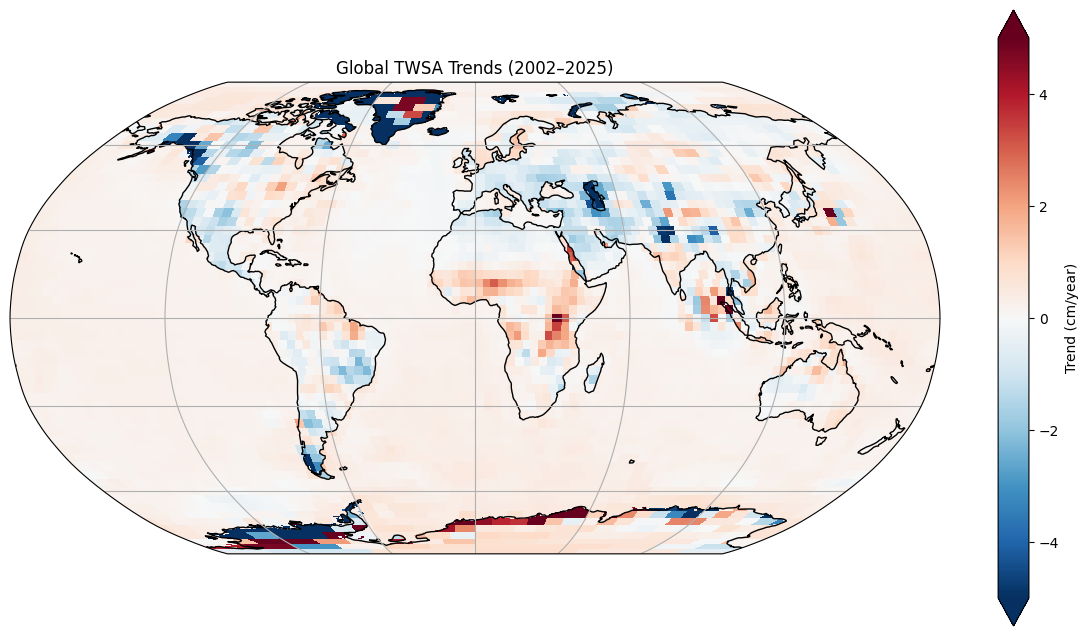

Strongest losses: Greenland, Antarctica, Central Valley (CA), Indo-Gangetic Plain.
Strongest increases: Hudson Bay, Alaska.
Stable regions: Amazon core, Siberia.
Patterns: Glacier melt in HMA/Patagonia; droughts in Sahel/US Southwest (La Niña); ENSO influences in Pacific.


In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.stats import linregress

# Function to compute trend (slope in cm/year)
def calculate_trend(da):
    def linreg(t, y):
        if np.all(np.isnan(y)):
            return np.nan
        valid = ~np.isnan(y)
        if np.sum(valid) < 3:
            return np.nan
        slope, _, _, _, _ = linregress(t[valid], y[valid])
        return slope * 12  # cm/year

    t = np.arange(len(da.time))

    return xr.apply_ufunc(
        linreg,
        t,
        da,
        input_core_dims=[['time'], ['time']],
        output_core_dims=[[]],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float]
    )

# Compute trends for GRACE lwe_thickness
trends = calculate_trend(ds['lwe_thickness'])

# Plot trend map
fig = plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.Robinson())
trends.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    vmin=-5, vmax=5,
    cbar_kwargs={'label': 'Trend (cm/year)'}
)
ax.coastlines()
ax.gridlines(draw_labels=False)
plt.title('Global TWSA Trends (2002–2025)')
plt.show()

# Interpret results
print("Strongest losses: Greenland, Antarctica, Central Valley (CA), Indo-Gangetic Plain.")
print("Strongest increases: Hudson Bay, Alaska.")
print("Stable regions: Amazon core, Siberia.")
print("Patterns: Glacier melt in HMA/Patagonia; droughts in Sahel/US Southwest (La Niña); ENSO influences in Pacific.")
